# National Data Science Bowl - Plankton

## Action Plan

* Make overfitting model
* Data augmentation
* Batch normalization
* Dropout
* Ensembling

## Imports and Directories

In [1]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
SCRIPTS_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data'

In [2]:
#import modules
from utils import *
%matplotlib inline

Using gpu device 0: GeForce GTX 1070 (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5105)
/home/nathan/anaconda3/envs/deepLearning/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [3]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR #'/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/home/nathan/git/planktonDataScienceBowl/scripts/data


## VGG Like Model

#### Constants

In [ ]:
img_rows, img_cols = 128, 128
in_shape = (img_rows, img_cols)
batch_size = 64
nb_classes = 121

#### Batches

In [ ]:
gen = image.ImageDataGenerator(rescale=1. / 255)
# gen = image.ImageDataGenerator()

In [ ]:
train_batches = get_batches(train_path, batch_size=batch_size, 
                            target_size=in_shape, color_mode="grayscale", 
                            gen=gen)
val_batches   = get_batches(valid_path, batch_size=batch_size, 
                            target_size=in_shape, color_mode="grayscale", 
                            gen=gen)

#### Model

In [ ]:
def get_model():
    model = Sequential([
        Convolution2D(64,3,3, border_mode='same', activation='relu', input_shape=(1, img_rows, img_cols)),
        Convolution2D(64,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Convolution2D(128,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Convolution2D(256,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(2048, activation='relu'),
        Dense(2048, activation='relu'),
        Dense(2048, activation='relu'),
        Dense(nb_classes, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = get_model()

In [ ]:
model.summary()

#### Train

In [ ]:
model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    nb_epoch=5,
                    validation_data=val_batches,
                    nb_val_samples=val_batches.nb_sample,
                    verbose=True)

In [ ]:
model.optimizer.lr=0.1
model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    verbose=True)

In [ ]:
model.optimizer.lr=0.01
model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    nb_epoch=4,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    verbose=True)

## Data Augmentation

#### Constants

In [14]:
img_rows, img_cols = 128, 128
in_shape = (img_rows, img_cols)
batch_size = 64
nb_classes = 121
mean_px = 0.046544086
std_px = 0.15035126

#### Batches

In [15]:
batch_gen = image.ImageDataGenerator(
                rotation_range=360,
                width_shift_range=0.03,
                height_shift_range=0.03,
                shear_range=0.10,
                zoom_range=0.10,
                rescale=1. / 255,
                horizontal_flip = True,
                vertical_flip = True)

valid_gen = image.ImageDataGenerator(
#                                      featurewise_center=True,
#                                      featurewise_std_normalization=True,
                                     rescale=1. / 255
                                    )

In [16]:
train_batches = get_batches(train_path, batch_size=batch_size, 
                            target_size=in_shape, color_mode="grayscale", 
                            gen=batch_gen)
val_batches   = get_batches(valid_path, batch_size=batch_size, 
                            target_size=in_shape, color_mode="grayscale", 
                            gen=valid_gen)

Found 27184 images belonging to 121 classes.
Found 3152 images belonging to 121 classes.


#### Model

In [17]:
def norm_input(x): return (x-mean_px)/(std_px)

In [18]:
def get_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1, img_rows, img_cols)),
        Convolution2D(64,3,3, border_mode='same', activation='relu'),
        Convolution2D(64,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Convolution2D(128,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Convolution2D(256,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(2048, activation='relu'),
        Dense(2048, activation='relu'),
        Dense(2048, activation='relu'),
        Dense(nb_classes, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
model = get_model()

/home/nathan/anaconda3/envs/deepLearning/lib/python3.5/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 128, 128)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 1, 128, 128)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 64, 128, 128)  640         lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 64, 128, 128)  36928       convolution2d_5[0][0]            
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 64, 64, 64)    0           convolution2d_6[0][0]            
___________________________________________________________________________________________

#### Train

In [21]:
history = model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    nb_epoch=25, verbose=True)

Epoch 1/25
27184/27184 [==============================] - 116s - loss: 2.8003 - acc: 0.2901 - val_loss: 2.2216 - val_acc: 0.3874
Epoch 2/25
27184/27184 [==============================] - 114s - loss: 1.9730 - acc: 0.4379 - val_loss: 1.8318 - val_acc: 0.4832
Epoch 3/25
27184/27184 [==============================] - 114s - loss: 1.7002 - acc: 0.4991 - val_loss: 1.6071 - val_acc: 0.5197
Epoch 4/25
27184/27184 [==============================] - 114s - loss: 1.5648 - acc: 0.5318 - val_loss: 1.5533 - val_acc: 0.5365
Epoch 5/25
27184/27184 [==============================] - 116s - loss: 1.4529 - acc: 0.5589 - val_loss: 1.4019 - val_acc: 0.5809
Epoch 6/25
27184/27184 [==============================] - 114s - loss: 1.3741 - acc: 0.5779 - val_loss: 1.4418 - val_acc: 0.5619
Epoch 7/25
27184/27184 [==============================] - 115s - loss: 1.3040 - acc: 0.5936 - val_loss: 1.2690 - val_acc: 0.6202
Epoch 8/25
27184/27184 [==============================] - 114s - loss: 1.2492 - acc: 0.6062 - val

In [22]:
model.save_weights('last_attempt_augmentation.h5')

#### Visualize Training

In [23]:
import seaborn as sns

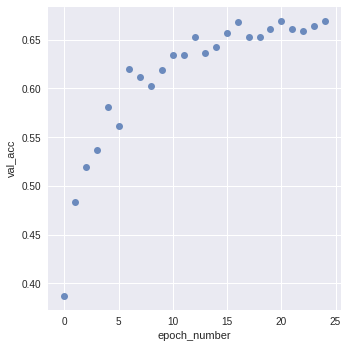

In [24]:
df = pd.DataFrame(history.history)
df['epoch_number'] = range(len(df))
sns.lmplot(x="epoch_number", y="val_acc", data=df, fit_reg=False)

## Batch Normalization 

## Dropout 

## Ensembling 